In [135]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import confusion_matrix

import pylab

def imagesc(x):
    plt.imshow(x,extent = [0,1,0,1])

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [136]:
name_prefix = 'pol_van_co_16_left_step4herz' # to save figures

matfile_path ='co_van_16_left_step4herz.mat'
matfile = loadmat(matfile_path)

ecog_trials = matfile['ecog_trials']
feat_trials = matfile['feat_trials']
posX_trials = matfile['posX_trials']
posY_trials = matfile['posY_trials']
par_trials = matfile['par_trials'][0]

del matfile

In [137]:
srate = 2048

numch_ecog = ecog_trials[0].shape[1]
fbandmins_len = feat_trials[0].shape[1]//numch_ecog

ch_idxs_motor = [18,19,20,21,48,49,50,51]
#ch_idxs_chosen = [0]
ch_idxs_chosen = [ch_idxs_motor[0]]

ch_idxs_all_chosen = []

for c in ch_idxs_chosen:
    feat_idxs_all = [c + numch_ecog*i for i in range(fbandmins_len)]
    for f in feat_idxs_all:
        ch_idxs_all_chosen.append(f)
ch_idxs_all_chosen.sort()
#ch_idxs_all_motor = ch_idxs_all_motor[-16:]
print(ch_idxs_all_chosen)

[18, 70, 122, 174, 226, 278, 330, 382, 434, 486, 538, 590, 642, 694, 746, 798, 850, 902, 954, 1006]


In [138]:
step_div = 8

num_w = int(2.5*step_div)

win_starts = np.arange(num_w)*srate//step_div
print(win_starts)

win_ends = win_starts + srate//4
print(win_ends)

[   0  256  512  768 1024 1280 1536 1792 2048 2304 2560 2816 3072 3328
 3584 3840 4096 4352 4608 4864]
[ 512  768 1024 1280 1536 1792 2048 2304 2560 2816 3072 3328 3584 3840
 4096 4352 4608 4864 5120 5376]


In [ ]:
numch_feat = feat_trials.shape[-1] 
cms_allch = np.zeros([len(ch_idxs_all_chosen),num_w,8,8])

kk = 0
for ch_idxs_chosen in ch_idxs_all_chosen:

    cms = np.zeros([num_w,8,8])

    for w in range(len(win_starts)):

        feat_trials_red = [feat_trials[i][win_starts[w]:win_ends[w]:128,ch_idxs_chosen].T for i in range(len(feat_trials))]

        feat_trials_red_flat = [feat_trials_red[i].reshape(-1) for i in range(len(feat_trials))]
        feat_trials_red_flat = np.array(feat_trials_red_flat)

        #print(feat_trials_red_flat.shape)

        # find optimal C
        #Cc_list = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

        Cc_list = [10000, 50000, 100000]

        Cc_scores = np.zeros(len(Cc_list))

        numit = 500

        k = 0
        for Cc in Cc_list:

            scores = np.zeros(numit)

            res_true = []
            res_pred = []

            for it in range(500):
                X_train, X_test, y_train, y_test = train_test_split(feat_trials_red_flat, par_trials, test_size=0.2)

                clf =  svm.SVC(kernel='rbf', C = Cc, shrinking = True).fit(X_train, y_train)

                scores[it] = clf.score(X_test, y_test)

                pred = clf.predict(X_test)
                res_pred.append(pred)
                res_true.append(y_test)

            #plt.hist(scores)

            #print(Cc)
            #print(np.mean(scores))
            Cc_scores[k] = np.mean(scores)

            k = k+1


        # use best C to build the classifier
        best_Cc_idx = np.argmax(Cc_scores)

        Cc = Cc_list[best_Cc_idx]

        scores = np.zeros(numit)

        res_true = []
        res_pred = []

        for it in range(500):
            X_train, X_test, y_train, y_test = train_test_split(feat_trials_red_flat, par_trials, test_size=0.2, stratify=par_trials)

            clf =  svm.SVC(kernel='rbf', C = Cc, shrinking = True).fit(X_train, y_train)

            scores[it] = clf.score(X_test, y_test)

            pred = clf.predict(X_test)
            res_pred.append(pred)
            res_true.append(y_test)

        #print(Cc)
        #print(np.mean(scores))


        # draw and save confusion matrix
        res_pred_flat = np.array(res_pred).reshape(-1)
        res_true_flat = np.array(res_true).reshape(-1)

        cm = confusion_matrix(res_true_flat,res_pred_flat)
        cms[w,:,:] = cm
        #plt.rcParams['figure.figsize'] = [10, 5]
        #plt.figure
        #imagesc(cm)
        #pylab.savefig(name_prefix+'cm_'+str(w))
        #plt.gcf().clear()

        #print('w = ')
        #print(w)
        #print(cm)
        #print(np.diag(cm)/np.sum(cm,axis=1))

    print('c = ')
    print(ch_idxs_chosen)

    cms_allch[kk,:,:,:] = cms
    kk = kk + 1

c = 
18
c = 
70
c = 
122
c = 
174
c = 
226


In [123]:
cms_allch[k,:,:,:] = cms

In [108]:
cms_allch.shape

(20, 20, 8, 8)

In [129]:
cms_allch[0]

array([[[ 28.,  51.,  31., ..., 139.,  61.,  27.],
        [ 62., 112.,  49., ...,  48.,  70.,  17.],
        [ 53.,  16.,  87., ...,  19.,  76.,  93.],
        ...,
        [113.,  45.,  34., ..., 125.,   8.,  36.],
        [187.,  80.,  32., ...,  20.,  71.,  33.],
        [ 71.,  99., 106., ...,  70.,   9.,   4.]],

       [[ 49.,  69.,  51., ..., 160.,   7.,  15.],
        [ 86.,   6., 116., ...,   3.,  40.,  10.],
        [ 32.,  86.,  94., ...,   2.,  79.,  20.],
        ...,
        [164.,  16.,  11., ..., 193.,   0.,  40.],
        [ 32., 139.,  90., ...,  48.,   4.,   5.],
        [ 37., 144., 102., ...,  50.,  62.,  11.]],

       [[220., 102.,  45., ...,  25.,   0.,   6.],
        [179.,   2.,  94., ...,  78.,  16.,  56.],
        [ 61.,  59.,  52., ...,   8., 139.,  88.],
        ...,
        [128.,  53.,  58., ...,  20.,  95.,   5.],
        [  1.,  74., 188., ...,  90.,   0., 100.],
        [ 98.,  32., 167., ...,  11.,  74.,  48.]],

       ...,

       [[ 21., 293.,  21

In [ ]:
fig = plt.figure(figsize=(20,5))
rect = fig.patch
plt.gcf().clear()

for p in range(8):
    ax = plt.subplot(1,8,p+1, polar=True)

    angles = [n*3.14/4 for n in range(8)]
    angles += angles[:1]

    cm_to_plot = np.concatenate((cm[p,:],[cm[p,0]]),axis=0)
    cm_to_plot.shape

    plt.plot(angles,cm_to_plot)
    plt.plot([angles[p],angles[p]],[0,200],'m')

    ax.set_rticks([]) 

    ms_into_trial = w*srate//step_div

    win_flash = 128
    if(ms_into_trial > 2048-win_flash)and(ms_into_trial < 2048+win_flash):
        ax.set_facecolor('xkcd:mint green')
    else:
        ax.set_facecolor('white')

if(ms_into_trial > 2048):
    plt.suptitle(str(ms_into_trial-2048)+' ms since GO-signal')
else:
    plt.suptitle(str(2048-ms_into_trial)+' ms to GO-signal')

pylab.savefig(name_prefix+'polar_'+str(w))
plt.gcf().clear()

In [8]:
acc = [np.diag(cms[i])/np.sum(cms[i],axis=1) for i in range(num_w)]

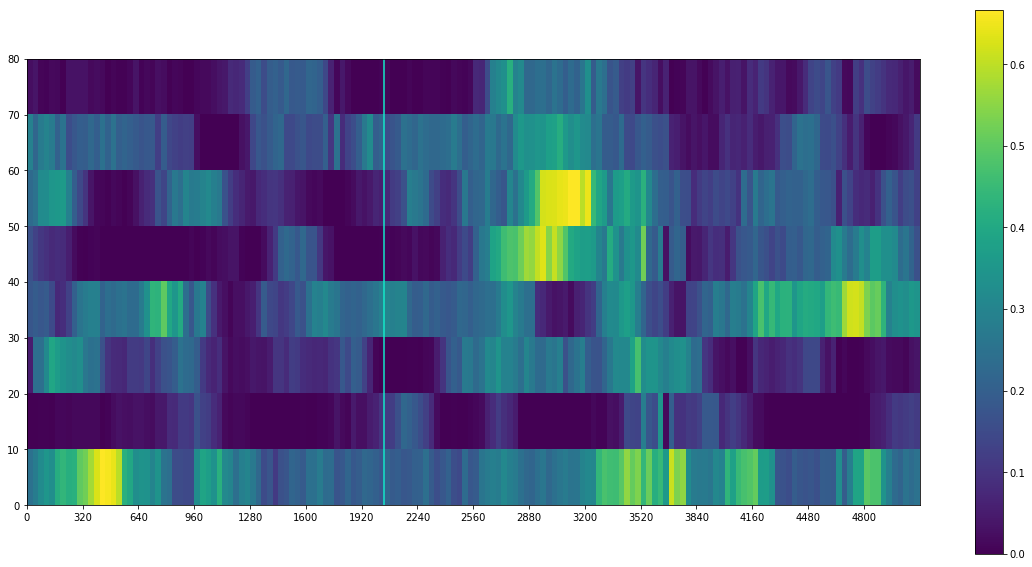

In [52]:
acc_np = np.array(acc)
acc_np.shape

plt.imshow(acc_np.T,extent = [0,160,0,80])
plt.xticks(np.arange(0, 160, step=10), win_starts[::10])
plt.axvline(2048//32,color='xkcd:aqua')
plt.colorbar()